In [1]:
audio_path = "audio-data/drumloop2.mp3"
name = "drumloop2-crude-spectral-mfccs"

# segmentation
block_length = 1 # number of frames in a stream block
BPM = 120
beat = 1 / 8 # metered divisions
hop_beats = 1 / 8 # hop length in beats
## alternatively, you can specify frame length and hop length in seconds
# frame_length_s = 0.1
# hop_length_s = 0.02
## or in samples
# frame_length = 4096
# hop_length = 1024

# feature extraction
extract_crude = True
extract_spectral = True
extract_mfccs = True

# clustering
n_classes = 3
maxlen = 16

# model architecture and training
step = 1 # step size for sliding window
hidden_units = 48 # number of hidden units in GRU layer
epochs = 25
batch_size = 32
validation_split = 0.2
early_stopping = False
checkpoint = True
patience = 5 # number of epochs to wait before early stopping

# utility
verbose = 1 # print additional information
directory = "."

In [2]:
# import dependencies
import argparse
from pathlib import Path
import math
import numpy as np, matplotlib.pyplot as plt, librosa
import matplotlib.ticker as mticker
import librosa.display
from IPython.display import Audio, display
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import json
from numpyencoder import NumpyEncoder
from sklearn import preprocessing, cluster
from streamer import Streamer
import scipy
from keras.utils import to_categorical
from keras import Sequential
import pickle

if BPM is None and beat is not None or BPM is not None and beat is None:
    print("Please specify both BPM and beat if you are using metered divisions.")
    exit()
frame_length_s = (4 * beat * 60 / BPM) if BPM is not None else frame_length_s
hop_length_s = (4 * hop_beats * 60 / BPM) if BPM is not None else hop_length_s
sr = librosa.get_samplerate(audio_path)
frame_length = math.ceil(frame_length_s * sr) if frame_length_s is not None else frame_length
hop_length = math.ceil(hop_length_s * sr) if hop_length_s is not None else hop_length
stream = Streamer(audio_path, block_length, frame_length, hop_length)
path = Path(directory + "/models/" + name)
path.mkdir(exist_ok=True, parents=True)

In [3]:
# helper function to extract features from audio block
def extract_features(y, sr, extract_crude=True, extract_spectral=False, extract_mfccs=False):
    if extract_crude:
        zcr = [librosa.zero_crossings(y).sum()]
        energy = [scipy.linalg.norm(y)]
    if extract_spectral:
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=hop_length, hop_length=hop_length)
        spectral_bandwith = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=hop_length, hop_length=hop_length)
        spectral_flatness = librosa.feature.spectral_flatness(y=y, n_fft=hop_length, hop_length=hop_length)
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=hop_length, hop_length=hop_length)
        m_centroid = np.median(spectral_centroid, axis=1)
        m_bandwith = np.median(spectral_bandwith, axis=1)
        m_flatness = np.median(spectral_flatness, axis=1)
        m_rolloff = np.median(spectral_rolloff, axis=1)
    if extract_mfccs:        
        if y.size >= 2048:  
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, center=False, n_fft=hop_length, hop_length=hop_length) # mfccs
        else:
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=len(y), hop_length=len(y), center=False)
        m_mfccs = np.median(mfccs[1:], axis=1)
    features = np.array([])
    if extract_crude:
            features = np.concatenate((
            features,
            zcr,
            energy
    ))
    if extract_spectral:
        features = np.concatenate((
            features,
            m_centroid,
            m_bandwith,
            m_flatness,
            m_rolloff
        ))
    if extract_mfccs:
        features = np.concatenate((
            features,
            m_mfccs
        ))
    if len(features) == 0:
        return None
    return features

Audio length: 192.0s, 9216000 samples
Sample rate: 48000 Hz
Frame length: 0.25s,  12000 samples
Hop length: 0.25s, 12000 samples
Block length: 1 frame(s)
Number of blocks: 768
(768, 18)
(768, 18)
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[-0.94301221  0.99960977 -0.99749423 -0.99265103 -0.99993997 -0.99531506
  0.99801783  0.99755365  0.59262146  0.99894882 -0.51168478  0.99309176
  0.87493413  0.99134794  0.37794501  0.99310999 -0.98271119  0.99318039]


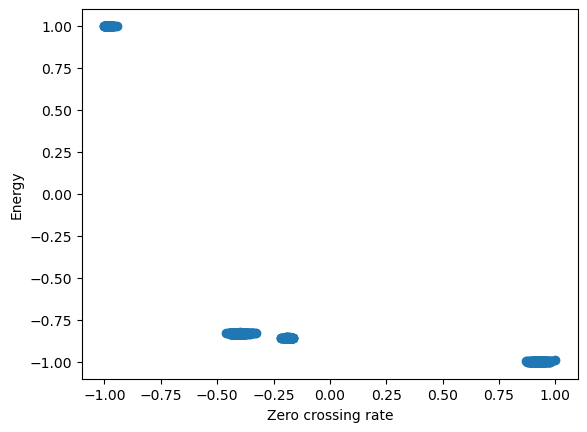

In [109]:
print(f"Audio length: {stream.length}s, {stream.n_samples} samples")
print(f"Sample rate: {sr} Hz")
print(f"Frame length: {frame_length_s}s,  {frame_length} samples")
print(f"Hop length: {hop_length_s}s, {hop_length} samples")
print(f"Block length: {block_length} frame(s)")
print(f"Number of blocks: {len(stream)}")

# extract features from each block in audio stream
features = np.array([extract_features(block, sr, extract_crude=extract_crude, extract_spectral=extract_spectral, extract_mfccs=extract_mfccs) for block in stream.new()])
# features_scaled = features
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
features_scaled = min_max_scaler.fit_transform(features)
# features_scaled = preprocessing.scale(features, axis=0) # should it be axis 0 then not 1??
if verbose:
    # print(features[0])
    print(features.shape)
    print(features_scaled.shape)
    print(features_scaled.min(axis=0))
    print(features_scaled.max(axis=0))
    print(features_scaled[0]) # type: ignore
if verbose:
    plt.scatter(features_scaled[:,0], features_scaled[:,1], ) # type: ignore
    if extract_crude:
        plt.xlabel('Zero crossing rate')
        plt.ylabel('Energy')
    elif extract_spectral:
        plt.xlabel('Spectral centroid')
        plt.ylabel('Spectral bandwidth')
    elif extract_mfccs:
        plt.xlabel('MFCC 1')
        plt.ylabel('MFCC 2')
    plt.show()
    # plt.scatter(features_scaled[:,0], features_scaled[:,1], ) # type: ignore
    # plt.show()

In [110]:
# cluster features
c_model = cluster.KMeans(n_clusters=n_classes, n_init='auto')
labels = c_model.fit_predict(features_scaled)
labels[:4]

/Users/wwerkowicz/miniforge3/envs/metal/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 0, 2, 0], dtype=int32)

/var/folders/kt/3yzrdbd548lfc1w4yd4phlwm0000gn/T/ipykernel_79845/296238387.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', n_classes)


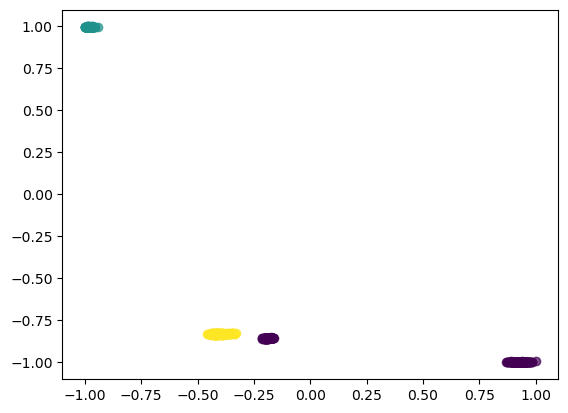

In [111]:
# Define a color map for the clusters
cmap = plt.cm.get_cmap('viridis', n_classes)

# Plot the data points with colors corresponding to their labels and add labels to legend
for i in range(n_classes):
    plt.scatter(features_scaled[labels==i, 0], features_scaled[labels==i, 1], color=cmap(i), alpha=0.7, label='Class {}'.format(i+1))
# plt.legend()
plt.savefig(path / (name + "_clusters.png"))
plt.show()

In [112]:
n_labels = len(np.unique(labels))
labels = labels.tolist()
# save labelled sequence of frames
labels_path = path / (name + "_labels.csv")
np.savetxt(labels_path, (labels), fmt='%s,')
if verbose:
    print(f"Total labelled frames: {len(labels)}")
    print(f"n_labels: {n_labels} (sanity check)")
    print("Labelled frame sequence saved to: " + str(labels_path))

Total labelled frames: 768
n_labels: 3 (sanity check)
Labelled frame sequence saved to: models/drumloop2-crude-spectral-mfccs/drumloop2-crude-spectral-mfccs_labels.csv


In [113]:

frames = []
for i, block in enumerate(stream.new()):
    frames.append([i * hop_length, i * hop_length + frame_length])
# frames # sanity check

# each dict value has to be a 1D interlaved array, as Max dict object has trouble reading 2D arrays
# start sample is always stored at an even index and is followed by end sample
labelled_frames = dict()
for label, frame in zip(labels, frames):
    if label not in labelled_frames:
        labelled_frames[label] = []
    labelled_frames[label].extend(frame) # use extend instead of append
if verbose:    
    print(len(labelled_frames[0])) # sanity check
    print(labelled_frames[0][0], labelled_frames[0][1]) # sanity check

# build a subsequence for every <step> frames
# and a corresponding label that follows it
x = [] # these will be features
y = [] # these will be targets
for i in range(0, len(labels) - maxlen, step):
    x.append(labels[i: i + maxlen])
    y.append(labels[i + maxlen])
# x_ = np.array(features)
# y_ = np.array(targets)
# one-hot encode features and targets
x_ = to_categorical(x, dtype ="bool")
y_ = to_categorical(y, dtype ="bool")
# sanity check
if verbose:
    print(x_.shape)
    print(y_.shape)

768
12000 24000
(752, 16, 3)
(752, 3)


In [122]:
# adapted from code by Lukas Biewald
# https://github.com/lukas/ml-class/blob/master/projects/7-text-generation/char-gen.py
model_path = path / (name + ".keras")
inputs = Input(shape=(maxlen, n_labels))
x = GRU(hidden_units)(inputs)
outputs = Dense(n_labels, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)
model._name = name
callbacks = []
if early_stopping:
    callbacks.append(EarlyStopping(
        monitor='val_loss',
        patience=patience
    ))
if checkpoint:
    callbacks.append(ModelCheckpoint(
        filepath=model_path,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    ))
model.compile(
    loss='categorical_crossentropy', # since we are using one-hot encoded labels
    optimizer="adam",
    metrics=['accuracy']
    )
model.summary()

history = model.fit(
    x_,
    y_,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
    validation_split=0.2,
    callbacks=callbacks
)

Model: "drumloop2-crude-spectral-mfccs"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 3)]           0         
                                                                 
 gru_1 (GRU)                 (None, 48)                7632      
                                                                 
 dense_1 (Dense)             (None, 3)                 147       
                                                                 
Total params: 7,779
Trainable params: 7,779
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
19/19 [==============================] - 1s 32ms/step - loss: 1.0634 - accuracy: 0.4260 - val_loss: 1.0210 - val_accuracy: 0.5033
Epoch 2/25
19/19 [==============================] - 0s 17ms/step - loss: 0.9959 - accuracy: 0.4992 - val_loss: 0.9641 - val_accuracy: 0.5033
Epoch 3/25
19/19

In [115]:
print(f"Saved model to: {path}")
d_path = path / (name + "_frames.json")
d_path.write_text(json.dumps(labelled_frames, cls=NumpyEncoder))
config = dict()
config["filename"] = audio_path.split('/')[-1]
config["sr"] = sr
config["BPM"] = BPM
config["beat"] = beat
config["n_classes"] = int(n_classes)
config["maxlen"] = int(maxlen)
config["onset_detection"] = False
config["hop_length"] = hop_length
config["frame_length"] = frame_length
config["block_length"] = block_length
c_path = path / (name + "_config.json")    
c_path.write_text(json.dumps(config))
if verbose:
    print(f"Saved model to: {model_path}")
    print(f"Saved frames to: {d_path}")
    print(f"Saved config to: {c_path}")

Saved model to: models/drumloop2-crude-spectral-mfccs
Saved model to: models/drumloop2-crude-spectral/drumloop2-crude-spectral.keras
Saved frames to: models/drumloop2-crude-spectral-mfccs/drumloop2-crude-spectral-mfccs_frames.json
Saved config to: models/drumloop2-crude-spectral-mfccs/drumloop2-crude-spectral-mfccs_config.json


In [123]:
history = history.history
h_path = path / (name + "_history")
with open(h_path, 'wb') as file_pi:
    pickle.dump(history, file_pi)
if verbose:
    print(f"Saved history to: {h_path}")

Saved history to: models/drumloop2-crude-spectral-mfccs/drumloop2-crude-spectral-mfccs_history


In [124]:
with open(h_path, "rb") as file_pi:
    history = pickle.load(file_pi)

In [125]:
print(f"Total epochs : {len(history['loss'])}")
print("Minimum validation loss: ", min(history['val_loss']), "\nEpoch: ", np.argmin(history['val_loss']))
print("Maximum validation accuracy: ", max(history['val_accuracy']), "\nEpoch: ", np.argmax(history['val_accuracy']))

Total epochs : 25
Minimum validation loss:  0.043624937534332275 
Epoch:  24
Maximum validation accuracy:  1.0 
Epoch:  5


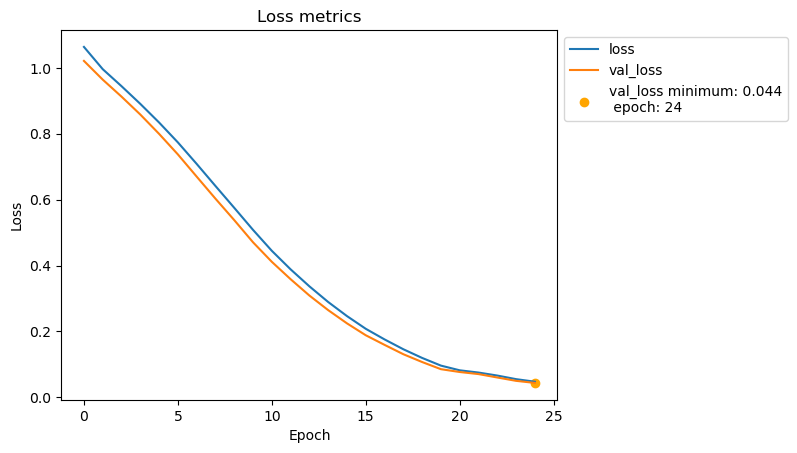

In [126]:
plt.plot(history["loss"], label="loss")
plt.plot(history["val_loss"], label="val_loss")
# plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
vl_min = min(history['val_loss'])
vl_min_epoch = np.argmin(history['val_loss'])
plt.scatter(vl_min_epoch, vl_min,c='orange', label=f'val_loss minimum: {vl_min:.3f}\n epoch: {vl_min_epoch}')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title("Loss metrics")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.tight_layout()
plt.savefig(path / (name + "_loss.png"), bbox_inches='tight')
plt.show()

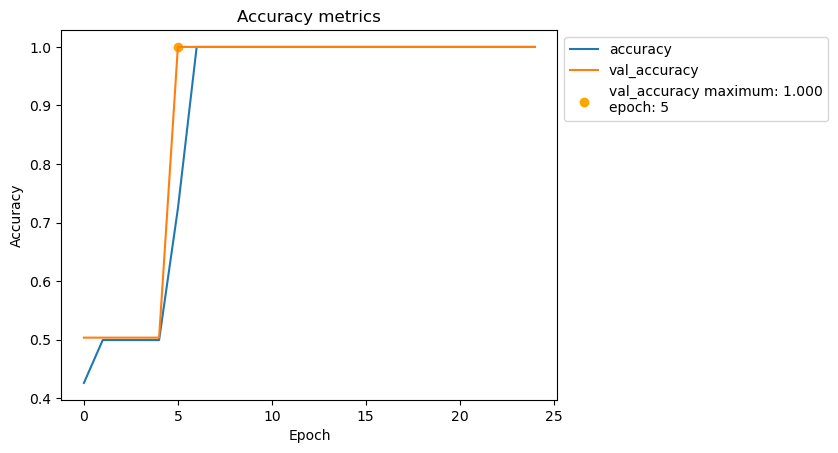

In [127]:
plt.plot(history["accuracy"], label="accuracy")
plt.plot(history["val_accuracy"], label="val_accuracy")
va_max = max(history['val_accuracy'])
va_max_epoch = np.argmax(history['val_accuracy'])
plt.scatter(va_max_epoch, va_max,c='orange', label=f'val_accuracy maximum: {va_max:.3f}\nepoch: {va_max_epoch}')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title("Accuracy metrics")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(path / (name + "_accuracy.png"), bbox_inches='tight')
plt.show()

In [128]:
seq = labels[:16]
print("Sequence do detokenise:\n", seq)
out = []
for label in seq:
    frame = stream.get_frame(labelled_frames, label, index=0)
    out = np.concatenate((out, frame))
display(Audio(out, rate=sr))

Sequence do detokenise:
 [1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0]


In [129]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = preds[0]
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    # print(preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [130]:
def generate(prompt=[], length=4, temperature=1.0, include_prompt=False, verbose=0):
    # print("Read prompt: ", prompt)
    # generate a sequence of given length       
    if len(prompt) == 0:
        # if it's there's no prompt, use an array of zeroes
        prompt = np.zeros((maxlen), dtype="uint8")
        print(f"No prompt provided, using {maxlen} zeroes instead.")
    elif len(prompt) < maxlen:
        # if prompt is too short, pad it with zeroes from the left to match correct input shape
        prompt = np.pad(prompt, (maxlen - len(prompt), 0), 'constant', constant_values=(0, 0))
        print("Prompt too short, padded to length: ", maxlen)
    elif len(prompt) > maxlen:
        # if it's too long, then trim it
        prompt = prompt[-maxlen:]
        print(f"Prompt too long, using {maxlen} last elements: ")
    prompt_ = to_categorical(prompt, num_classes=n_classes)
    prompt_ = np.array([prompt_])
    
    seq = []
    for i in range(length):
        # make prediction based on prompt
        ps = model.predict(prompt_, verbose=verbose)
        # sample from predictions
        p_label = sample(ps, temperature)
        # add sampled label to sequence
        seq.extend([int(p_label)])
        # one-hot encode sampled label
        p_label_ = to_categorical(p_label, num_classes=n_classes)
        p_label_ = np.array([[p_label_]])
        # append encoded label to the prompt for next prediction
        prompt_ = np.append(prompt_, p_label_, axis=1)
    if include_prompt:
        prompt = np.append(prompt, seq)
        return prompt
    else:
        return seq

In [131]:
seq_ = generate(seq, length=16, temperature=1.0, include_prompt=False)
print("Generated sequence:\n", seq_)
out = []
for label in seq_:
    frame = stream.get_frame(labelled_frames, label, index=0)
    out = np.concatenate((out, frame))
display(Audio(out, rate=sr))

Generated sequence:
 [1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0]


In [132]:
seq_ = generate(seq, length=16, temperature=1.5, include_prompt=False)
print("Generated sequence:\n", seq_)
out = []
for label in seq_:
    frame = stream.get_frame(labelled_frames, label, index=0)
    out = np.concatenate((out, frame))
display(Audio(out, rate=sr))

Generated sequence:
 [2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 2, 1]


In [133]:
seq_ = generate(seq, length=16, temperature=2.0, include_prompt=False)
print("Generated sequence:\n", seq_)
out = []
for label in seq_:
    frame = stream.get_frame(labelled_frames, label, index=0)
    out = np.concatenate((out, frame))
display(Audio(out, rate=sr))

Generated sequence:
 [1, 0, 1, 2, 0, 2, 0, 0, 1, 0, 2, 1, 0, 2, 0, 1]


In [134]:
seq_ = generate(seq, length=16, temperature=3.0, include_prompt=False)
print("Generated sequence:\n", seq_)
out = []
for label in seq_:
    frame = stream.get_frame(labelled_frames, label, index=0)
    out = np.concatenate((out, frame))
display(Audio(out, rate=sr))

Generated sequence:
 [1, 2, 0, 2, 0, 2, 1, 1, 0, 2, 0, 1, 0, 0, 2, 1]
